In [189]:
#Import Libraries
%matplotlib inline 
import keras
import nltk
import pandas as pd
import numpy as np
import re
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.util import ngrams
from nltk.corpus import stopwords
import datetime
from collections import Counter
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
stop = stopwords.words('english')

### Setting Up the Groundwork

In [208]:
#Functions
def sanitize_text(df, col):
    df[col+' Cleaned'] = df[col].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[col+' Cleaned'] = df[col+' Cleaned'].replace('[^\w\s]', '')
    df[col+' Cleaned'] = df[col+' Cleaned'].str.lower()
    return df

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

def rank_words(terms, feature_matrix):
    """
    Display top comments by topic.
    """
    sums = feature_matrix.sum(axis=0)
    data = []
    for col, term in enumerate(terms):
        data.append( (term, sums[0,col]) )
    ranked = pd.DataFrame(data, columns=['term','rank']).sort_values('rank', ascending=False)
    return ranked

In [3]:
#Read data
df = pd.read_csv("data.csv")
df.head(10)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses
5,5,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",2,0,4,General,Dresses,Dresses
6,6,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,5,1,1,General Petite,Tops,Knits
7,7,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,1,4,General Petite,Tops,Knits
8,8,1077,24,Flattering,I love this dress. i usually get an xs but it ...,5,1,0,General,Dresses,Dresses
9,9,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0,General,Dresses,Dresses


In [4]:
#Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
Unnamed: 0                 23486 non-null int64
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


In [5]:
#Drop columns we don't need.
df.drop('Unnamed: 0', axis=1, inplace=True)

### Data Overview

#### Missing Data

Text(0, 0.5, 'Number of Missing Values')

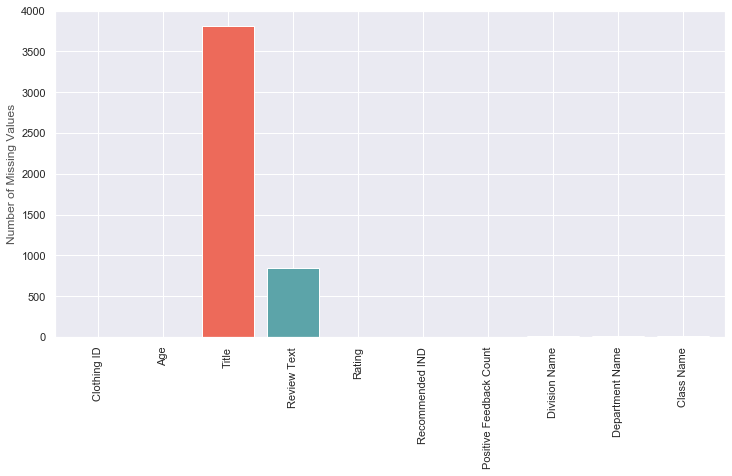

In [9]:
#Look at missing data
sns.set(rc={'figure.figsize':(12,6)})
my_colors = (('#ED6A5A', '#5CA4A9'))
ax = pd.isnull(df).sum().plot(kind='bar', color=my_colors, width=0.8)
ax.set_ylabel('Number of Missing Values', size=12, alpha = 0.8)
#ax.set_facecolor("lightgrey")
#ax.yaxis.grid(color='#E6EBE0', linestyle='-', linewidth=1)

We will have to remove all rows that do not contain a review field, but for now, since we want to visualize the data first, it is important we keep all values.  

#### Pivot Tables

In [145]:
tab = pd.crosstab(df['Division Name'], df["Department Name"])
tab

Department Name,Bottoms,Dresses,Intimate,Jackets,Tops,Trend
Division Name,,,,,,
General,2540,3730,0,645,6837,96
General Petite,1257,2589,233,387,3631,23
Initmates,0,0,1501,0,0,0


From the looks of it, general sizes tops are the most common item, while trendy petite items are not.

#### Ratings

In [13]:
#Look at ratings
df.groupby("Rating").count()

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
Rating,,,,,,,,,
1,842,842,691,821,842,842,842,842,842
2,1565,1565,1360,1549,1565,1565,1565,1565,1565
3,2871,2871,2464,2823,2871,2871,2871,2871,2871
4,5077,5077,4289,4908,5077,5077,5077,5077,5077
5,13131,13131,10872,12540,13131,13131,13117,13117,13117


Text(0.5, 0, 'Rating')

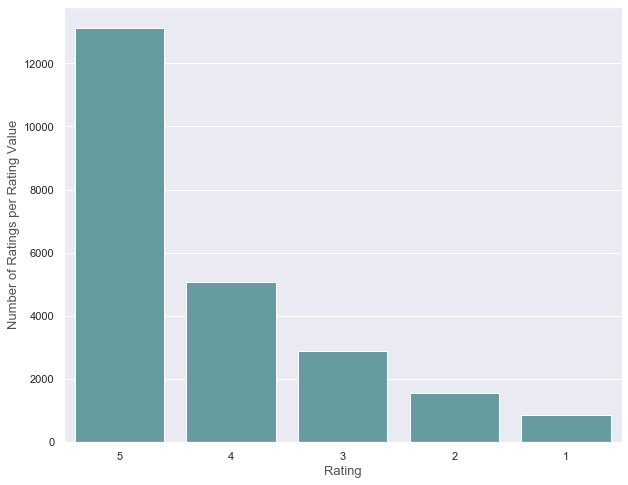

In [32]:
#Look at the number of ratings
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.countplot(df.Rating, color = '#5CA4A9', order= df["Rating"].value_counts().index)
ax.set_ylabel('Number of Ratings per Rating Value', size=13, alpha = 0.8)
ax.set_xlabel('Rating', size=13, alpha = 0.8)

The above shows our classes are not completely balanced, but we will deal with that later (resampling, over/under sampling). This is not always a bad thing per se, but when your classes are very disproportionate, your model will naturally favor the majority class given that it has the highest probability.  

#### Classes

In [15]:
#Look at the types of items being reviewed
df.groupby("Class Name").count()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name
Class Name,,,,,,,,,
Blouses,3097,3097,2587,2983,3097,3097,3097,3097,3097
Casual bottoms,2,2,1,1,2,2,2,2,2
Chemises,1,1,1,1,1,1,1,1,1
Dresses,6319,6319,5372,6145,6319,6319,6319,6319,6319
Fine gauge,1100,1100,927,1059,1100,1100,1100,1100,1100
Intimates,154,154,120,147,154,154,154,154,154
Jackets,704,704,598,683,704,704,704,704,704
Jeans,1147,1147,970,1104,1147,1147,1147,1147,1147
Knits,4843,4843,3981,4626,4843,4843,4843,4843,4843


As a woman, not too surprised to find the biggest reviews come from dresses, knits and sweaters. At this point, we don't know yet whether this are positive or negative reviews, but we know women are discussing them often. This is likely due to the fact that all three categories are staple items in most women's closets.  Dropping 'casual bottoms' and 'chemises' as the sample size is very small.

Text(0.5, 0, 'Class Name')

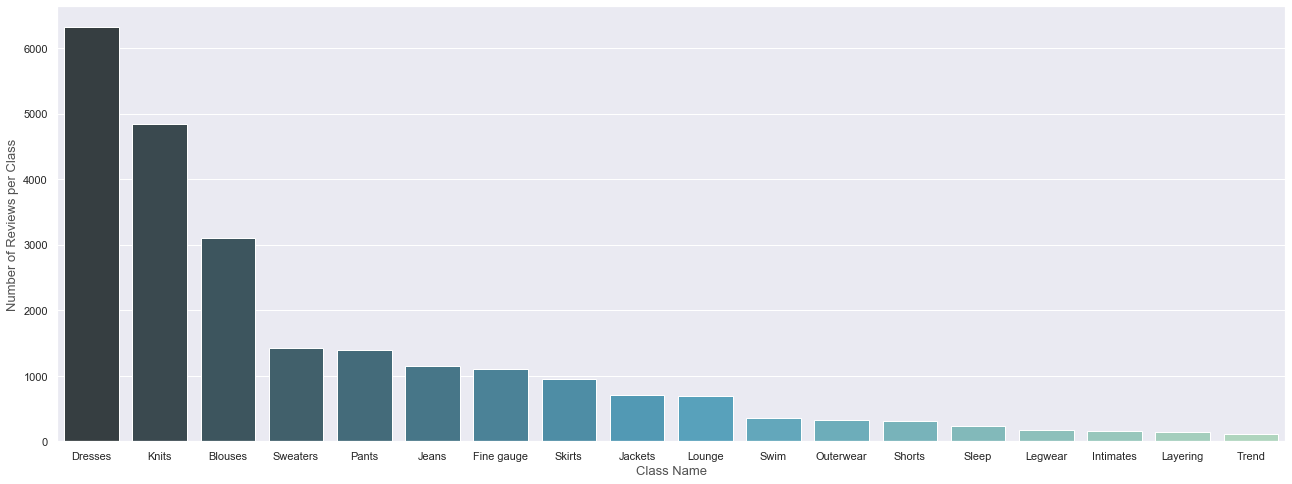

In [58]:
#Look at the number of reviews per class
df = df[(df['Class Name'] != 'Casual bottoms') & (df['Class Name'] != 'Chemises')]
sns.set(rc={'figure.figsize':(22,8)})
ax = sns.countplot(df['Class Name'], palette = "GnBu_d", order= df["Class Name"].value_counts().index)
ax.set_ylabel('Number of Reviews per Class', size=13, alpha = 0.8)
ax.set_xlabel('Class Name', size=13, alpha = 0.8)

In [16]:
#Let's look at the mean positive feedback count and rating by class name
df.groupby("Class Name")['Positive Feedback Count'].mean()

Class Name
Blouses           2.725218
Casual bottoms    0.000000
Chemises          0.000000
Dresses           3.087514
Fine gauge        2.013636
Intimates         0.779221
Jackets           2.826705
Jeans             1.759372
Knits             2.394797
Layering          1.315068
Legwear           1.272727
Lounge            2.321274
Outerwear         2.823171
Pants             2.396974
Shorts            1.675079
Skirts            2.293122
Sleep             1.750000
Sweaters          2.208683
Swim              2.142857
Trend             3.369748
Name: Positive Feedback Count, dtype: float64

The classes with the most positive feedback are trendy clothes and dresses.  Trendy clothes, I believe, makes sense given that most people follow trends religiously and once a handful of people like an item, many more will follow. The class names with the least positive feedback are intimiates.

In [166]:
#Let's look at the mean positive feedback count and rating by class name
df.groupby("Class Name")['Rating'].mean()

Class Name
Blouses           4.154020
Casual bottoms    4.500000
Chemises          4.000000
Dresses           4.150815
Fine gauge        4.260909
Intimates         4.279221
Jackets           4.295455
Jeans             4.360942
Knits             4.161677
Layering          4.376712
Legwear           4.278788
Lounge            4.301013
Outerwear         4.198171
Pants             4.265850
Shorts            4.255521
Skirts            4.245503
Sleep             4.285088
Sweaters          4.179272
Swim              4.197143
Trend             3.815126
Name: Rating, dtype: float64

Ratings wise it all looks pretty uniform and for data like this, it's not uncommon. It is worth noting that trendy clothes scored on average lower on the rating scale, yet high on the positive feedback count which supports my theory that trendy clothes get a lot of followers, but they're not necessarily quality or durable clothing items.

#### Age

Text(0, 0.5, 'Density')

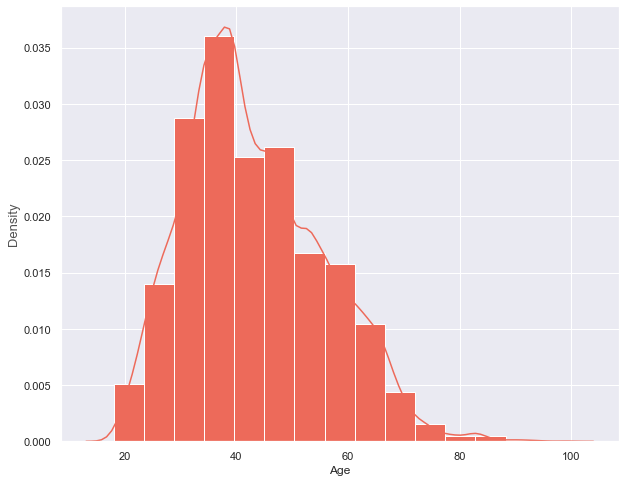

In [117]:
#Look at the number of reviews per Age
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.distplot(df.Age, color = '#ED6A5A',hist_kws=dict(alpha=1), bins=15,)
ax.set_ylabel('Density', size=13, alpha = 0.8)

It seems most reviews come from women between the ages of 35 and 50. This is also not too surprising given that usually as we get older we are more aware of the things we like and dislike.  

Text(0.5, 17.200000000000003, 'Rating')

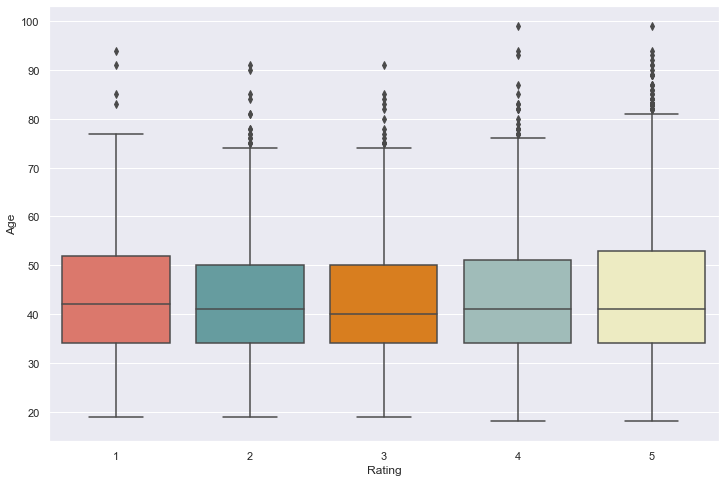

In [116]:
#Age vs. Rating
sns.set(rc={'figure.figsize':(12,8)})
my_colors = (('#ED6A5A', '#5CA4A9', '#F77F00', '#9BC1BC', '#F4F1BB'))
sns.boxplot(x = 'Rating', y = 'Age', data = df, palette = my_colors)
ax.set_ylabel('Age', size=13, alpha = 0.8)
ax.set_xlabel('Rating', size=13, alpha = 0.8)

While the previous post showed that women between the ages of 35 and 50 wrote more reviews, when it comes to ratings (the plot above), it seems age does not have an effect.

#### Unique Ids

In [37]:
df.groupby("Clothing ID")['Review Text'].count().sort_values(ascending=False)

Clothing ID
1078    987
862     778
1094    735
1081    561
872     519
829     512
1110    471
868     414
895     384
936     348
867     333
850     324
1095    323
863     291
1059    287
1077    287
1086    283
1080    280
860     276
1083    244
861     228
873     223
1092    219
828     213
1033    212
927     207
1056    206
820     202
836     197
1022    195
       ... 
746       1
744       1
714       1
723       1
6         0
143       0
786       0
284       0
1201      0
1029      0
1164      0
457       0
77        0
351       0
92        0
342       0
97        0
64        0
337       0
379       0
102       0
234       0
244       0
852       0
544       0
618       0
36        0
459       0
31        0
0         0
Name: Review Text, Length: 1203, dtype: int64

Text(0, 0.5, 'Number of Reviews per Clothing Item')

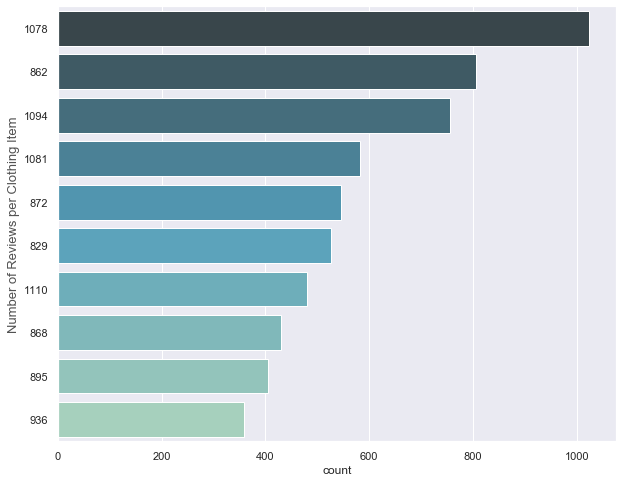

In [115]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.countplot(y='Clothing ID', data = df[df["Clothing ID"].isin(df["Clothing ID"].value_counts()[:10].index)], palette = "GnBu_d", order= df["Clothing ID"].value_counts()[:10].index)
ax.set_ylabel('Number of Reviews per Clothing Item', size=13, alpha = 0.8)

It seems a handful of items contain most of the reviews. I am interested to see the positive feedback of these items and the terms used for reviewing these items.

In [52]:
ids_interest = [1078, 862, 1094, 1081, 872]
df_int = df[df['Clothing ID'].isin(ids_interest)]
df_int.groupby('Clothing ID')['Rating'].mean().sort_values(ascending=False)

Clothing ID
872     4.383486
1081    4.281787
1078    4.204102
862     4.200993
1094    4.189153
Name: Rating, dtype: float64

In [60]:
#Average rating overall
df['Rating'].describe()

count    23483.000000
mean         4.196014
std          1.110088
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: Rating, dtype: float64

The ratings of the top items is slightly higher than average.

#### Recommended vs. Not Recommended Products


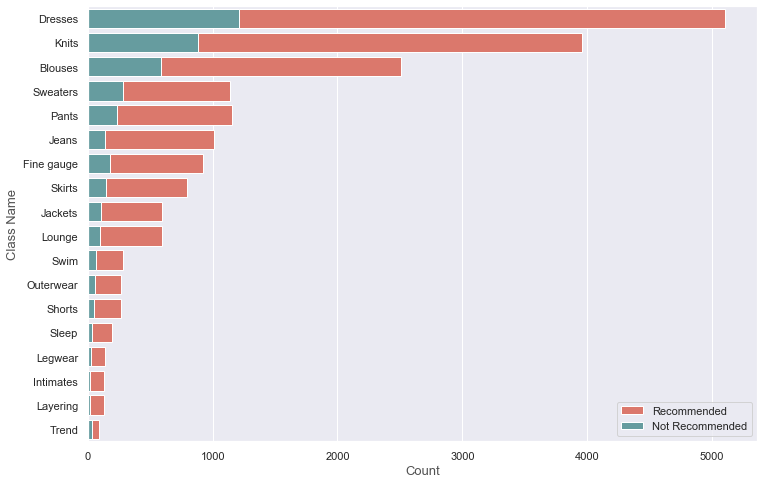

In [113]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.countplot(y='Class Name', data=df[df['Recommended IND']==1] ,color='#ED6A5A', label = "Recommended", order= df["Class Name"].value_counts().index)
ax = sns.countplot(y='Class Name', data=df[df['Recommended IND']==0] ,color='#5CA4A9', label = "Not Recommended", order= df["Class Name"].value_counts().index)
ax.set_ylabel('Class Name', size=13, alpha = 0.8)
ax.set_xlabel('Count', size=13, alpha = 0.8)
ax = plt.legend()

It seeems that dresses has the most recommended and not recommended items. Do keep in mind this is the biggest class group; hence, we can't make a strong case on this one.

### Variable Correlations

In [85]:
#Initial exploration
df.corr()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
Clothing ID,1.000000,0.017419,-0.018837,-0.015968,0.046166
Age,0.017419,1.000000,0.026860,0.030687,0.043023
Rating,-0.018837,0.026860,1.000000,0.792350,-0.064955
Recommended IND,-0.015968,0.030687,0.792350,1.000000,-0.069021
Positive Feedback Count,0.046166,0.043023,-0.064955,-0.069021,1.000000


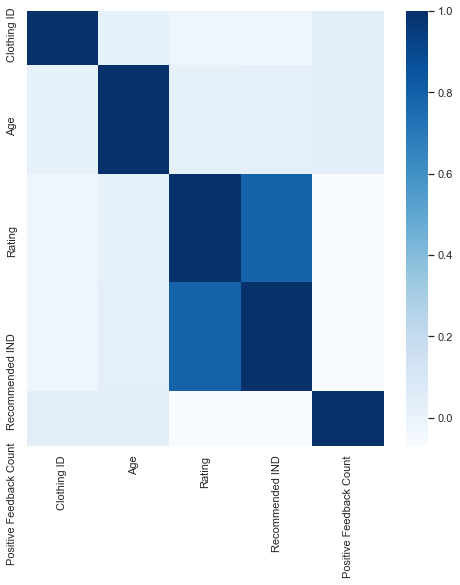

In [89]:
sns.set(rc={'figure.figsize':(8,8)})
sns.heatmap(df.corr(), cmap = 'Blues')

A quick glance at this shows correlations between the recommended IND and the rating - which makes sense - if you're willing to recommend the product, you're also willing to rate it highly. There are also seems to be correlations between Age and Recommend IND and Rating.  

In [98]:
#Compute likelihoods to checkout correlations further
df_corr = (df.groupby("Class Name")[["Rating","Recommended IND", "Age"]]
        .aggregate(['count','mean']))

In [99]:
df_corr.columns = ["Count","Rating Mean","Recommended Likelihood Count",
                "Recommended Likelihood","Age Count","Age Mean"]
df_corr.drop(["Recommended Likelihood Count","Age Count"], axis=1, inplace =True)


In [100]:
df_corr.head()

,Count,Rating Mean,Recommended Likelihood,Age Mean
Class Name,,,,
Blouses,3097,4.154020,0.810139,44.252502
Dresses,6319,4.150815,0.808197,42.114892
Fine gauge,1100,4.260909,0.837273,44.730909
Intimates,154,4.279221,0.857143,39.155844
Jackets,704,4.295455,0.845170,43.813920


#### Regressions

In [105]:
import statsmodels.api as sm
model_fit = sm.OLS(temp["Recommended Likelihood"],
               sm.add_constant(temp["Age Mean"])).fit() 
temp['resid'] = model_fit.resid

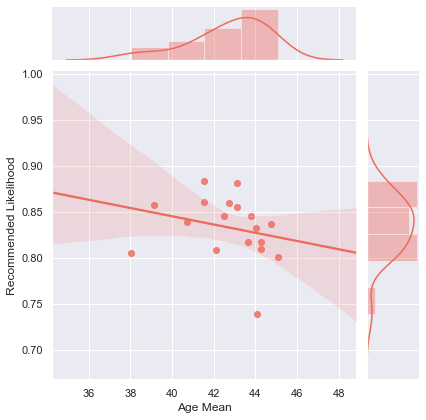

In [124]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.jointplot(y="Recommended Likelihood",x='Age Mean',data=df_corr, kind='reg', color='#ED6A5A')

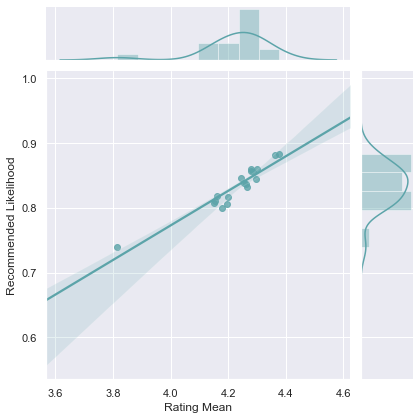

In [123]:
model_fit = sm.OLS(temp["Recommended Likelihood"],
               sm.add_constant(temp["Rating Mean"])).fit() 
temp['resid'] = model_fit.resid

sns.set(rc={'figure.figsize':(12,8)})
ax = sns.jointplot(y="Recommended Likelihood",x='Rating Mean',data=df_corr, kind='reg', color='#5CA4A9')

We can certainly see proportional relationships among these variables. A word of caution though the data itself is disproportionate; hence,mwe have to be careful when making these claims.

### NLP: Words and Classification

Okay, so far, what do we know? We know that there are proportional relationships between product recommendations, age and ratings. We also know that Dresses and Knits are the most popular departments.  Let's see how NLP can help us understand these relationships better.

In [84]:
#Clean text
df = sanitize_text(df, "Review Text")
df['Review Text Cleaned'].head()

0    absolutely wonderful   silky and sexy and comf...
1    love this dress!  it's sooo pretty   i happene...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit  it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: Review Text Cleaned, dtype: object

In [246]:
#Drop nulls
df = df[df['Review Text'].notnull()].reset_index(drop=True)
df = df[df['Department Name'].notnull()].reset_index(drop=True)

#### Feature Selection

In [152]:
#Compute features
#Number of words
df['word_count'] = df['Review Text Cleaned'].apply(lambda x: len(str(x).split(" ")))
df[['Review Text','word_count']].head()

,Review Text,word_count
0,Absolutely wonderful - silky and sexy and comf...,9
1,Love this dress! it's sooo pretty. i happene...,73
2,I had such high hopes for this dress and reall...,103
3,"I love, love, love this jumpsuit. it's fun, fl...",23
4,This shirt is very flattering to all due to th...,38


In [153]:
df.word_count.mean()

65.60210256636778

In [159]:
#Average word length
df['avg_word'] = df['Review Text'].apply(lambda x: avg_word(x))
df[['Review Text','avg_word']].head()

,Review Text,avg_word
0,Absolutely wonderful - silky and sexy and comf...,5.750000
1,Love this dress! it's sooo pretty. i happene...,3.822581
2,I had such high hopes for this dress and reall...,4.112245
3,"I love, love, love this jumpsuit. it's fun, fl...",4.681818
4,This shirt is very flattering to all due to th...,4.361111


In [161]:
df.avg_word.mean()

4.194405932069491

In [154]:
#Character Count
df['char_count'] = df['Review Text'].str.len() ## this also includes spaces
df[['Review Text','char_count']].head()

,Review Text,char_count
0,Absolutely wonderful - silky and sexy and comf...,53
1,Love this dress! it's sooo pretty. i happene...,303
2,I had such high hopes for this dress and reall...,500
3,"I love, love, love this jumpsuit. it's fun, fl...",124
4,This shirt is very flattering to all due to th...,192


In [157]:
df.char_count.mean()

308.70104686602764

In [163]:
#Stopwords
df['stopwords'] = df['Review Text'].apply(lambda x: len([x for x in x.split() if x in stop]))
df[['Review Text','stopwords']].head()

,Review Text,stopwords
0,Absolutely wonderful - silky and sexy and comf...,2
1,Love this dress! it's sooo pretty. i happene...,30
2,I had such high hopes for this dress and reall...,45
3,"I love, love, love this jumpsuit. it's fun, fl...",6
4,This shirt is very flattering to all due to th...,19


In [165]:
df.stopwords.mean()

29.00150183311984

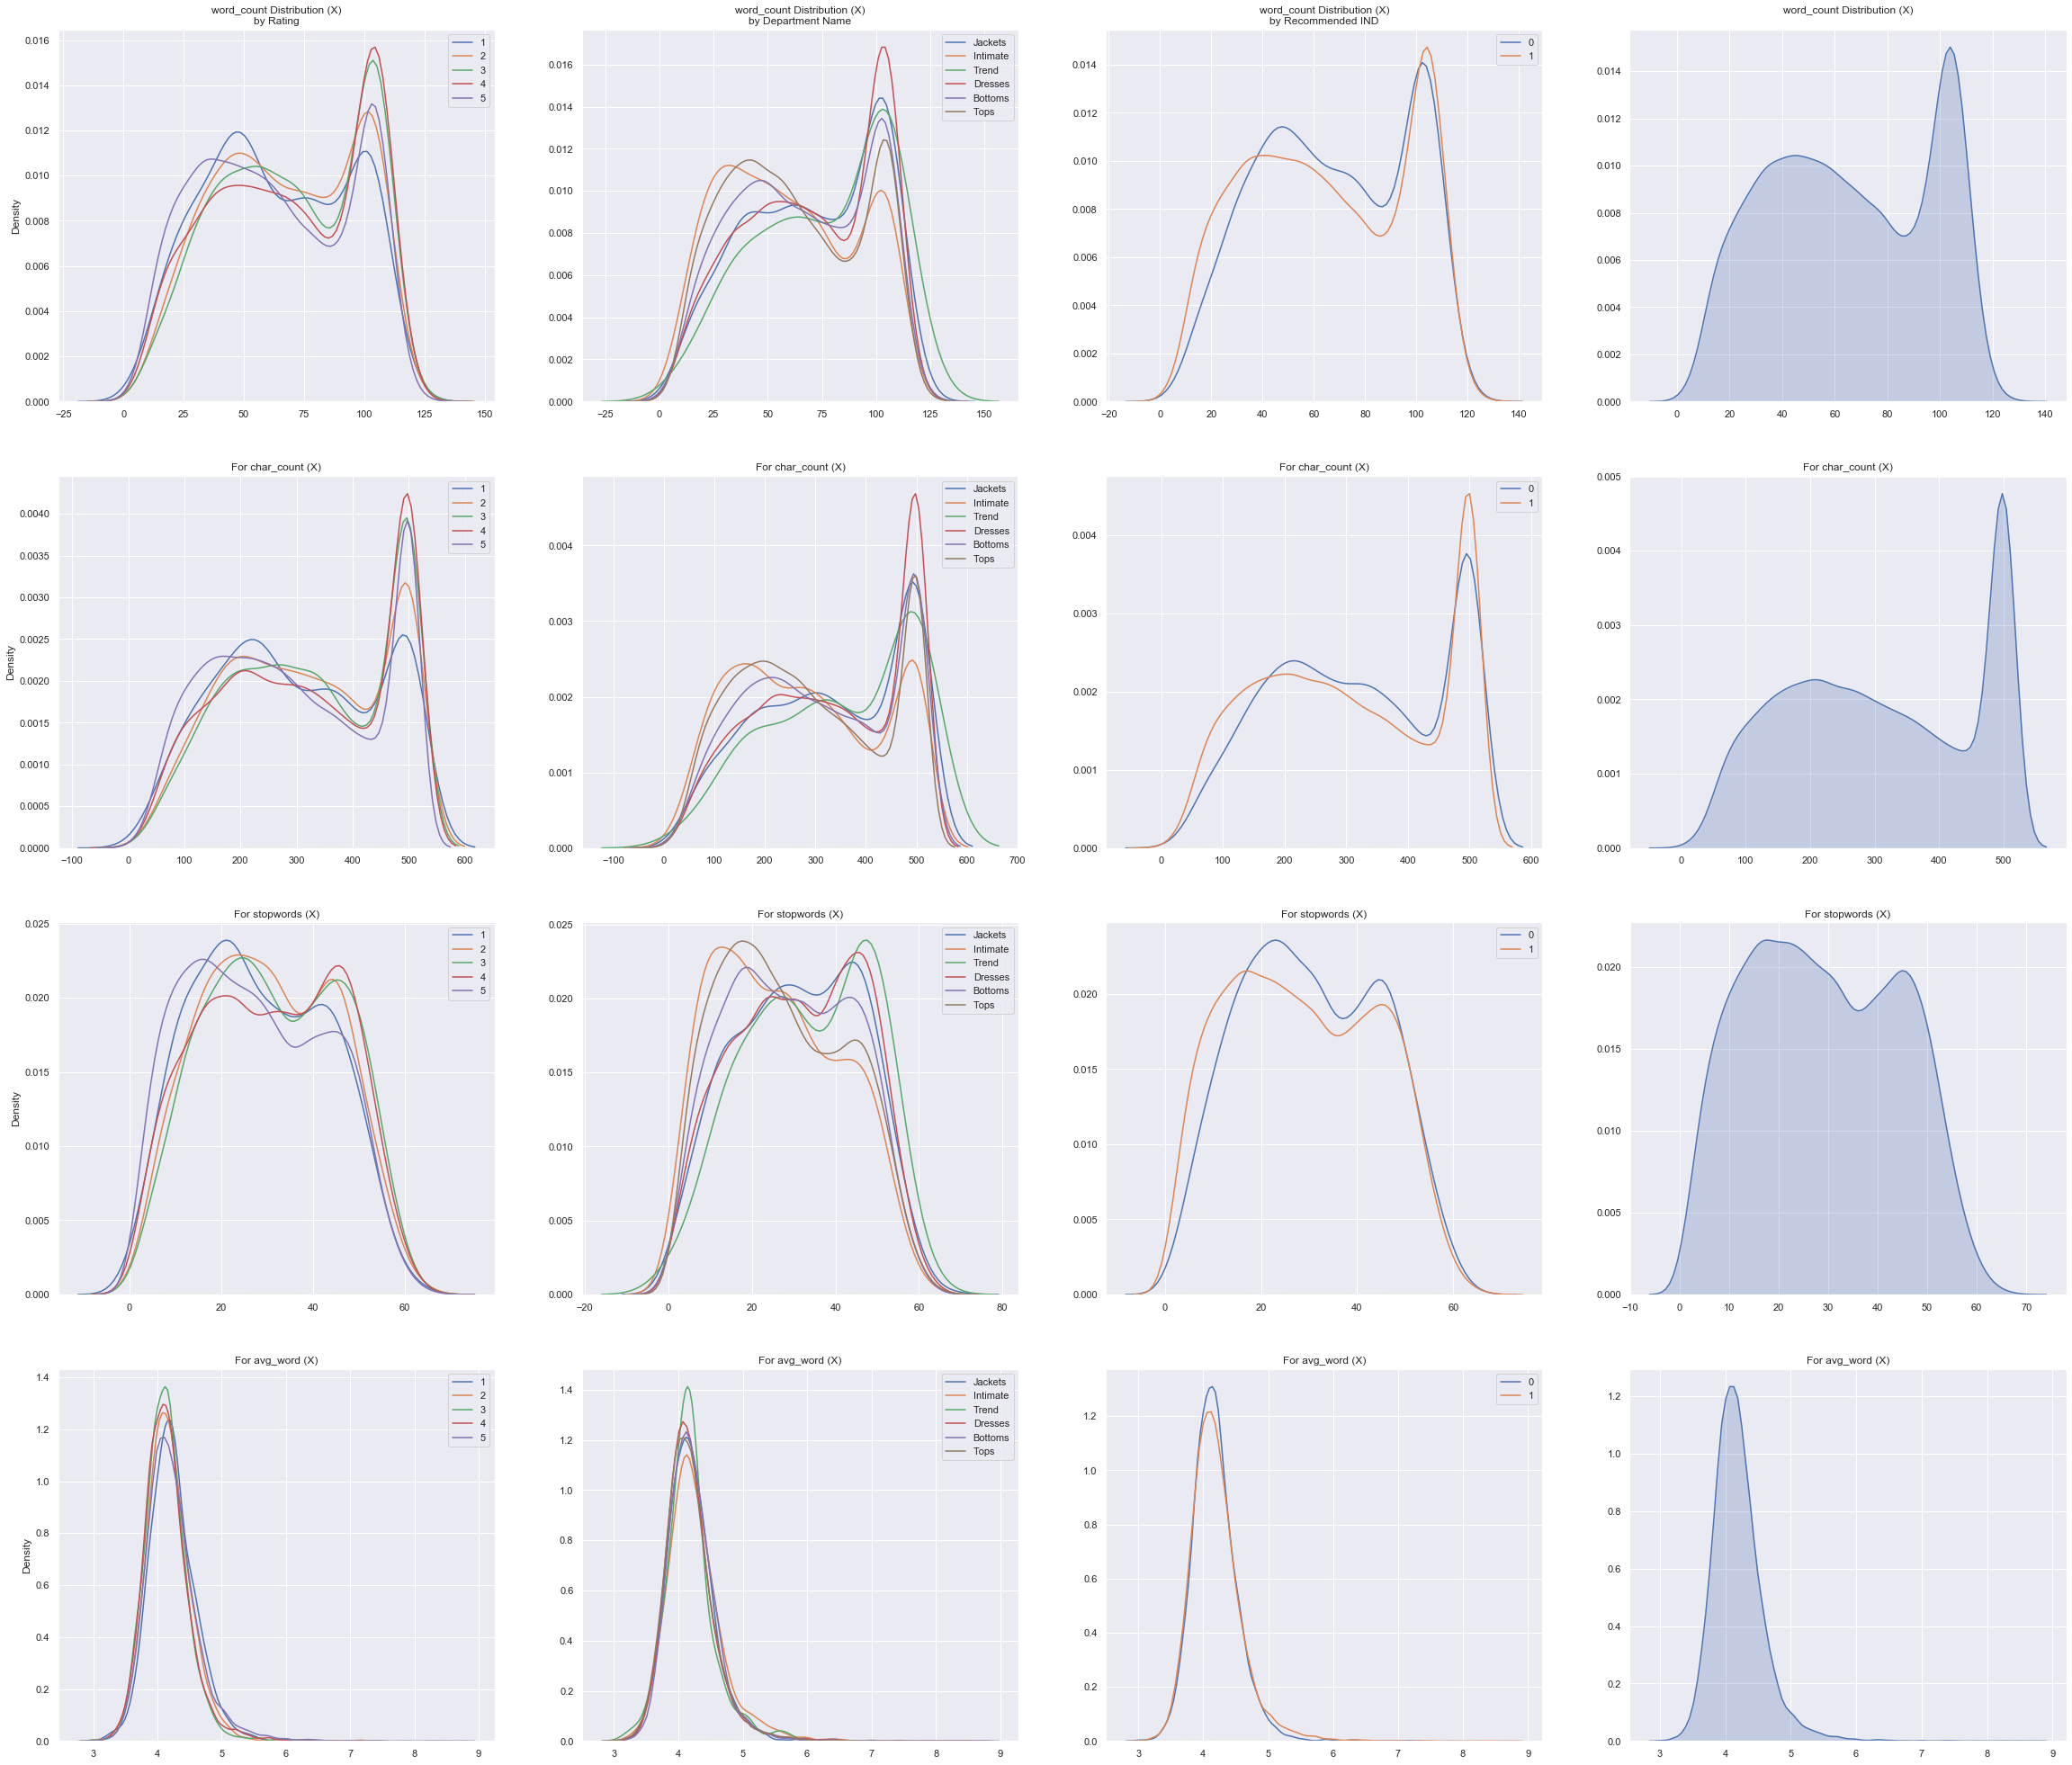

,count,mean,std,min,25%,50%,75%,max
word_count,22639.0,65.602103,30.645301,2.0,40.000000,64.000000,96.000000,128.00
char_count,22639.0,308.701047,143.938791,9.0,186.000000,301.000000,459.000000,508.00
avg_word,22639.0,4.194406,0.391952,3.0,3.945946,4.151515,4.385965,8.75
stopwords,22639.0,29.001502,15.052008,0.0,16.000000,28.000000,42.000000,68.00


In [176]:
#Visualize features
f, axes = plt.subplots(4,4, figsize=(40,35), sharex=False)
for ii, xvar in enumerate(['word_count', "char_count", "stopwords", "avg_word"]):
    for i,y in enumerate(["Rating","Department Name","Recommended IND"]):
        for x in set(df[y][df[y].notnull()]):
            sns.kdeplot(df[xvar][df[y]==x], label=x, shade=False, ax=axes[ii,i])
        if ii is 0:
            axes[ii,i].set_title('{} Distribution (X)\nby {}'.format(xvar, y))
        else:
            axes[ii,i].set_title('For {} (X)'.format(xvar))
    axes[ii,0].set_ylabel('Density')
    axes[ii,i].set_xlabel('')
    # Plot 4
    sns.kdeplot(df[xvar],shade=True,ax=axes[ii,3])
    axes[ii,3].set_xlabel("")
    if ii is 0:
        axes[ii,3].set_title('{} Distribution (X)\n'.format(xvar))
    else:
        axes[ii,3].set_title('For {} (X)'.format(xvar))
    axes[ii,3].legend_.remove()
plt.show()

df[["word_count","char_count", "avg_word", "stopwords"]].describe().T

A lot of interesting information can be seen here. First thing I notice is that in-between scores like 3 and 4 have the most words, longest words, least stopwords which makes me think there's more substance to those reviews, perhaps in between items need longer explanations for the given rating.


I also notice that the longest reviews come from the Dresses category.
Recommended items also have the longest reviews, not by a lot though - as we saw earlier this field may due to a popularity effect instead of an unbiased review.

#### Deeper with Words

In [183]:
#remove stopwords
df['Review Text Cleaned'] = df['Review Text Cleaned'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [184]:
#most frequent terms
freq = pd.Series(' '.join(df['Review Text Cleaned']).split()).value_counts()[:10]
freq

dress    9415
love     8629
size     8087
like     7040
fit      6797
top      6421
wear     6296
great    5613
i'm      5563
would    5006
dtype: int64

In [186]:
#most frequent terms
freq = pd.Series(' '.join(df['Review Text Cleaned']).split()).value_counts()[-10:]
freq

alt          1
scoured      1
stats!       1
speaker      1
amterial,    1
stomach),    1
constr       1
(5'2"),      1
arrows,      1
masters      1
dtype: int64

I'm actually ok not removing any of these words.

#### TF IDF

Let's try to determine the most important words in the recommended and not recommended fielfs, by department and age group.

In [229]:
#Important words by Recommended IND
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3,5))
labels = [0, 1]
for i in range(len(labels)):
    print("Recommended IND: "+str(labels[i]))
    temp = df[df['Recommended IND'] == labels[i]]
    tfidf = vectorizer.fit_transform(temp['Review Text Cleaned'])
    ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
    print(ranked[0:10])
    print("\n\n")

Recommended IND: 0
                      term      rank
210406  really wanted love  4.785445
295836   wanted love dress  4.377261
210354  really wanted like  3.130128
296229     wanted love top  2.565213
156067      made look like  2.265666
135701  like maternity top  2.209673
299036     way much fabric  2.133458
91697        fit true size  2.054677
221684    sadly going back  2.029649
183458  ordered usual size  1.884945



Recommended IND: 1
                              term       rank
410395              fits true size  18.648956
166981               can wait wear  14.140178
403735               fit true size  12.561112
924282   received many compliments  11.948211
677600              love love love  10.503173
964022              runs true size  10.300901
1262192          usually wear size   6.988575
342569             every time wear   6.511748
658382           looks great jeans   6.343554
475014        got many compliments   5.813461





In [238]:
#Important Words By Class | NOT Recommended
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3,5))
labels = df['Department Name'].unique().tolist()
for i in range(len(labels)):
    print("Department Name: "+labels[i])
    temp = df[(df['Department Name'] == labels[i]) & (df['Recommended IND'] == 0)]
    tfidf = vectorizer.fit_transform(temp['Review Text Cleaned'])
    ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
    print(ranked[0:10])
    print("\n\n")

Department Name: Intimate
                          term      rank
15223       super itchy return  1.000000
12110       really wanted love  0.574542
17383         wanted love suit  0.435767
11054    picture hit hips good  0.408248
11845  quality robes purchased  0.408248
18216   wore bodysuit hole arm  0.408248
1679            body huge arms  0.408248
1516         big secure enough  0.408248
1517    big secure enough wear  0.408248
11053         picture hit hips  0.408248



Department Name: Dresses
                           term      rank
92458         wanted love dress  3.817285
68269        really wanted love  1.809948
68276  really wanted love dress  1.197778
26762         excited get dress  1.125325
68253        really wanted like  1.030140
56881       never write reviews  1.000000
38319          high hopes dress  0.990905
21488         dress looked like  0.970250
45101      like maternity dress  0.846457
48292          looked like sack  0.842627



Department Name: Bottoms
     

In [240]:
#Important Words By Class | Recommended
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3,5))
labels = df['Department Name'].unique().tolist()
for i in range(len(labels)):
    print("Department Name: "+labels[i])
    temp = df[(df['Department Name'] == labels[i]) & (df['Recommended IND'] == 1)]
    tfidf = vectorizer.fit_transform(temp['Review Text Cleaned'])
    ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
    print(ranked[0:10])
    print("\n\n")

Department Name: Intimate
                             term      rank
28777              fits true size  2.222613
28336               fit true size  1.477208
47372              love love love  1.155270
27843              fit like glove  1.004094
33307     gotten many compliments  1.003326
18882              cute true size  1.000000
37533  initially attracted colors  1.000000
11989               can wait wear  0.999764
92291           wear around house  0.934033
90106              ve gotten many  0.930944



Department Name: Dresses
                             term      rank
133537             fits true size  5.916450
49718               can wait wear  5.358503
278868  received many compliments  4.591318
8335        absolutely love dress  3.841712
209336             love love love  3.473089
290819             runs true size  3.120135
101341            dress well made  3.054843
132552            fits like glove  2.973136
153674       got many compliments  2.634786
131317              fi

In [247]:
#Set Up Ages
ages = ["20-30", "30-40", "40-50", "50+"]
agesR=[]
for i in range(len(df['Review Text'])):
    if df['Age'][i] > 20 and df['Age'][i] <=30:
        r = ages[0]
    elif df['Age'][i] > 30 and df['Age'][i] <=40:
        r = ages[1]
    elif df['Age'][i] > 40 and df['Age'][i] <=50:
        r = ages[2]
    else:
        r = ages[3]
    agesR.append(r)
df['Age Range'] = agesR

In [249]:
#Important Words By Age | Recommended
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3,5))
labels = df['Age Range'].unique().tolist()
for i in range(len(labels)):
    print("Age Range: "+labels[i])
    temp = df[(df['Age Range'] == labels[i]) & (df['Recommended IND'] == 1)]
    tfidf = vectorizer.fit_transform(temp['Review Text Cleaned'])
    ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
    print(ranked[0:10])
    print("\n\n")

Age Range: 30-40
                             term      rank
137938             fits true size  6.973112
56267               can wait wear  4.890436
311500  received many compliments  4.737230
135571              fit true size  4.370285
228563             love love love  4.309287
324921             runs true size  3.078268
115198            every time wear  2.777238
324533            runs little big  2.283780
159476       got many compliments  2.240802
1449                 115 lbs 30dd  2.237463



Age Range: 50+
                             term      rank
121769             fits true size  6.538653
49531               can wait wear  4.849446
119730              fit true size  4.735668
285547             runs true size  3.675337
200730             love love love  3.454515
273805  received many compliments  2.862746
373851          usually wear size  2.825182
238806         ordered usual size  2.665784
195130          looks great jeans  2.540985
372685           usual size small  2.1947

In [250]:
#Important Words By Age | Recommended
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(3,5))
labels = df['Age Range'].unique().tolist()
for i in range(len(labels)):
    print("Age Range: "+labels[i])
    temp = df[(df['Age Range'] == labels[i]) & (df['Recommended IND'] == 0)]
    tfidf = vectorizer.fit_transform(temp['Review Text Cleaned'])
    ranked = rank_words(terms=vectorizer.get_feature_names(), feature_matrix=tfidf)
    print(ranked[0:10])
    print("\n\n")

Age Range: 30-40
                         term      rank
75685      really wanted love  2.333400
106406      wanted love dress  1.690799
75665      really wanted like  1.348705
106562        wanted love top  1.319640
107564        way much fabric  1.200971
62343     never write reviews  1.156095
79805        sadly going back  1.155376
64312          one going back  1.084366
104801      usually wear size  1.010579
94278   sweater cute scratchy  1.000000



Age Range: 50+
                                  term      rank
72278                wanted love dress  1.383489
15459  disappointment price outrageous  1.000000
41331                 much right short  1.000000
38106                   made look like  0.785158
65786                thin quality poor  0.712838
51740               really wanted love  0.682596
45004               ordered usual size  0.673822
39191            material thin quality  0.588173
39192       material thin quality poor  0.588173
37833                low waisted we